# Polling data exploration notebook

In [1]:
# ============================================================================
# Setup and initial load
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

warnings.filterwarnings("ignore")

# Configure pandas display options
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
pd.set_option("display.width", None)

# ==================== POLITICAL CONSTANTS ====================

# Current electoral swing states (update for different election cycles)
SWING_STATES = [
    "Arizona",  # 11 electoral votes
    "Georgia",  # 16 electoral votes
    "Michigan",  # 15 electoral votes
    "Nevada",  # 6 electoral votes
    "North Carolina",  # 16 electoral votes
    "Pennsylvania",  # 19 electoral votes - largest swing state
    "Wisconsin",  # 10 electoral votes
]

# Main candidates to focus analysis on
MAIN_CANDIDATES = ["Donald Trump", "Joe Biden", "Kamala Harris"]

print("Setup complete - ready for data exploration!")
print(f"Swing states: {len(SWING_STATES)} defined")
print(f"Main candidates: {len(MAIN_CANDIDATES)} defined")

Setup complete - ready for data exploration!
Swing states: 7 defined
Main candidates: 3 defined


In [2]:
# ============================================================================
# Load and basic overview
# ============================================================================

# Load data
file_path = "president_polls.csv"
print(f"Loading data from: {file_path}")

try:
    df = pd.read_csv(file_path)
    print(f"Successfully loaded!")
    print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
    print(
        f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB"
    )  # Large dataset (> 200 MB) may make sampling the better option
except Exception as e:
    print(f"Error: {e}")
    print("Check your file path and try again.")

Loading data from: president_polls.csv
Successfully loaded!
Shape: 18,095 rows × 52 columns
Memory usage: 31.4 MB


In [3]:
# ============================================================================
# Column overview and data types
# ============================================================================

print("COLUMN OVERVIEW:")
print("=" * 80)

# Show all columns with data types and non-null counts
df_info = pd.DataFrame(
    {
        "Column": df.columns,
        "Data_Type": df.dtypes,
        "Non_Null_Count": df.count(),
        "Null_Count": df.isnull().sum(),
        "Null_Percentage": (df.isnull().sum() / len(df) * 100).round(2),
        "Unique_Values": [df[col].nunique() for col in df.columns],
        "Sample_Values": [
            (
                str(df[col].dropna().iloc[0])[:50] + "..."
                if len(df[col].dropna()) > 0
                else "No data"
            )
            for col in df.columns
        ],
    }
)

print(df_info.to_string(index=False))

COLUMN OVERVIEW:
                   Column Data_Type  Non_Null_Count  Null_Count  Null_Percentage  Unique_Values                                         Sample_Values
                  poll_id     int64           18095           0             0.00           3730                                              89372...
              pollster_id     int64           18095           0             0.00            241                                               1528...
                 pollster    object           18095           0             0.00            241                                         AtlasIntel...
              sponsor_ids    object            8482        9613            53.13            278                                          2152,2170...
                 sponsors    object            8482        9613            53.13            278             On Point Politics | Red Eagle Politics...
             display_name    object           18095           0             0.00   

In [4]:
# ============================================================================
# Key column deep dive
# ============================================================================

print("\nKEY COLUMN ANALYSIS:")
print("=" * 80)

# Candidates
print("CANDIDATE ANALYSIS:")
print("=" * 40)
if "candidate_name" in df.columns:  # In case different data source is used
    candidate_counts = df["candidate_name"].value_counts()
    print(f"Total unique candidates: {candidate_counts.shape[0]}")
    print(f"Top 10 candidates by poll count:")
    for candidate, count in candidate_counts.head(10).items():
        print(f"   {candidate}: {count:,} polls")

    # Check for main candidates
    print(f"\nMain candidate coverage:")
    for candidate in MAIN_CANDIDATES:
        count = candidate_counts.get(candidate, 0)
        print(f"   {candidate}: {count:,} polls")
else:
    print("No 'candidate_name' column found")


KEY COLUMN ANALYSIS:
CANDIDATE ANALYSIS:
Total unique candidates: 64
Top 10 candidates by poll count:
   Donald Trump: 5,973 polls
   Joe Biden: 3,883 polls
   Kamala Harris: 2,652 polls
   Jill Stein: 1,379 polls
   Robert F. Kennedy: 1,346 polls
   Cornel West: 952 polls
   Chase Oliver: 827 polls
   Ron DeSantis: 466 polls
   Nikki Haley: 152 polls
   Lars Mapstead: 59 polls

Main candidate coverage:
   Donald Trump: 5,973 polls
   Joe Biden: 3,883 polls
   Kamala Harris: 2,652 polls


In [5]:
# ============================================================================
# Date analysis
# ============================================================================

print("\nDATE ANALYSIS:")
print("=" * 40)

if "end_date" in df.columns:
    print("Raw date samples:")
    print(df["end_date"].head(10).tolist())

    # Try parsing dates
    try:
        df["end_date_parsed"] = pd.to_datetime(df["end_date"], format="mixed")

        print(f"\nDate parsing successful!")
        print(
            f"Date range: {df['end_date_parsed'].min()} to {df['end_date_parsed'].max()}"
        )
        print(
            f"Total days covered: {(df['end_date_parsed'].max() - df['end_date_parsed'].min()).days:,} days"
        )

        # Show temporal distribution
        df["year"] = df["end_date_parsed"].dt.year
        df["month"] = df["end_date_parsed"].dt.month

        yearly_counts = df["year"].value_counts().sort_index()
        print(f"\nPolls by year:")
        for year, count in yearly_counts.items():
            print(f"   {year}: {count:,} polls")

    except Exception as e:
        print(f"Date parsing failed: {e}")
else:
    print("No 'end_date' column found")


DATE ANALYSIS:
Raw date samples:
['11/4/24', '11/4/24', '11/4/24', '11/4/24', '11/4/24', '11/4/24', '11/4/24', '11/4/24', '11/4/24', '11/4/24']

Date parsing successful!
Date range: 2021-04-07 00:00:00 to 2024-11-04 00:00:00
Total days covered: 1,307 days

Polls by year:
   2021: 195 polls
   2022: 1,122 polls
   2023: 3,938 polls
   2024: 12,840 polls


In [6]:
# ============================================================================
# Polling percentage analysis
# ============================================================================

print("\nPOLLING PERCENTAGE ANALYSIS:")
print("=" * 40)

if "pct" in df.columns:
    print("Percentage statistics:")
    print(df["pct"].describe())

    print(f"\nData quality check:")
    print(
        f"   Missing values: {df['pct'].isnull().sum():,} ({df['pct'].isnull().sum()/len(df)*100:.1f}%)"
    )
    print(f"   Negative values: {(df['pct'] < 0).sum():,}")
    print(f"   Values > 100%: {(df['pct'] > 100).sum():,}")
    print(f"   Zero values: {(df['pct'] == 0).sum():,}")

    # Show distribution
    print(f"\nPercentage distribution:")
    bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    pct_dist = (
        pd.cut(df["pct"], bins=bins, include_lowest=True).value_counts().sort_index()
    )
    for range_val, count in pct_dist.items():
        if count > 0:
            print(f"   {range_val}: {count:,} results")
else:
    print("No 'pct' column found")


POLLING PERCENTAGE ANALYSIS:
Percentage statistics:
count    18095.000000
mean        33.572380
std         18.576735
min          0.000000
25%         16.000000
50%         42.000000
75%         46.900000
max         70.000000
Name: pct, dtype: float64

Data quality check:
   Missing values: 0 (0.0%)
   Negative values: 0
   Values > 100%: 0
   Zero values: 734

Percentage distribution:
   (-0.001, 10.0]: 4,299 results
   (10.0, 20.0]: 313 results
   (20.0, 30.0]: 211 results
   (30.0, 40.0]: 2,694 results
   (40.0, 50.0]: 9,468 results
   (50.0, 60.0]: 1,048 results
   (60.0, 70.0]: 62 results


In [7]:
# ============================================================================
# Geographic analysis
# ============================================================================

print("\nGEOGRAPHIC ANALYSIS")
print("=" * 40)

if "state" in df.columns:
    # Get all unique state values including NaN
    state_counts = df["state"].value_counts(dropna=False)
    total_polls = df["poll_id"].nunique() if "poll_id" in df.columns else "Unknown"

    print(f"Total polls: {total_polls:,}")
    print(f"Total unique state values: {len(state_counts)}")

    print(f"\nALL STATE VALUES (sorted by frequency):")
    print("Look through this list to identify national indicators:")
    print("-" * 20)

    # Iterate through state_counts (already sorted by frequency)
    for i, (state, count) in enumerate(state_counts.items(), 1):
        # Handle NaN display
        if pd.isna(state):
            display_value = "NaN (missing)"
        else:
            display_value = f"'{state}'"

        percentage = (count / len(df)) * 100
        print(f"   {i:2d}. {display_value:<25}: {count:>6,} ({percentage:>5.1f}%)")

    print(f"\nMANUAL DECISION NEEDED:")
    print(f"   Based on the list above, identify:")
    print(f"   Which values represent NATIONAL polls?")
    print(f"\n   Copy the exact values (including quotes/spelling) for the next cell!")

else:
    print("No 'state' column found")


GEOGRAPHIC ANALYSIS
Total polls: 3,730
Total unique state values: 56

ALL STATE VALUES (sorted by frequency):
Look through this list to identify national indicators:
--------------------
    1. NaN (missing)            :  8,024 ( 44.3%)
    2. 'Pennsylvania'           :  1,206 (  6.7%)
    3. 'Michigan'               :  1,160 (  6.4%)
    4. 'Wisconsin'              :  1,027 (  5.7%)
    5. 'Arizona'                :    915 (  5.1%)
    6. 'Georgia'                :    888 (  4.9%)
    7. 'North Carolina'         :    809 (  4.5%)
    8. 'Nevada'                 :    650 (  3.6%)
    9. 'Florida'                :    411 (  2.3%)
   10. 'Texas'                  :    308 (  1.7%)
   11. 'Virginia'               :    293 (  1.6%)
   12. 'Ohio'                   :    250 (  1.4%)
   13. 'California'             :    233 (  1.3%)
   14. 'New Hampshire'          :    204 (  1.1%)
   15. 'Minnesota'              :    165 (  0.9%)
   16. 'New York'               :    105 (  0.6%)
   17. 'Mary

In [ ]:
# No national indicators, all national polls are recorded as NaN

if "state" in df.columns:
    print(f"CLASSIFICATION RULES:")
    print(f"   Swing states: {SWING_STATES}")
    print(f"   NaN values: Treated as national polls")

    # Apply explicit classification
    def classify_geographic_scope(state_value):
        """Classify polls by geographic scope using explicit rules."""
        if pd.isna(state_value):
            return "National"
        elif state_value in SWING_STATES:
            return "Swing State"
        else:
            return "Other State"

    # Apply classification to create new column
    df["geographic_scope"] = df["state"].apply(classify_geographic_scope)

    # Show summary results
    print(f"\nCLASSIFICATION RESULTS:")
    geo_summary = df["geographic_scope"].value_counts()
    total_polling_data = len(df)

    for scope, count in geo_summary.items():
        percentage = (count / total_polling_data) * 100
        print(f"   {scope}: {count:,} polling results ({percentage:.1f}%)")

    # Detailed breakdown for validation
    print(f"\nDETAILED BREAKDOWN:")

    # Show swing state coverage
    swing_breakdown = df[df["geographic_scope"] == "Swing State"][
        "state"
    ].value_counts()
    if len(swing_breakdown) > 0:
        print(f"\n   SWING STATE coverage:")
        for state in SWING_STATES:
            count = swing_breakdown.get(state, 0)
            status = "Found" if count > 0 else "No data"
            print(f"      {state}: {count:,} entries")

    # Show top other states
    other_breakdown = df[df["geographic_scope"] == "Other State"][
        "state"
    ].value_counts()
    if len(other_breakdown) > 0:
        print(f"\n   Top OTHER STATES:")
        for state, count in other_breakdown.head(5).items():
            print(f"      {state}: {count:,} entries")

    print(f"\nGeographic classification complete!")

else:
    print("No 'state' column found")

CLASSIFICATION RULES:
   Swing states: ['Arizona', 'Georgia', 'Michigan', 'Nevada', 'North Carolina', 'Pennsylvania', 'Wisconsin']
   NaN values: Treated as national polls

CLASSIFICATION RESULTS:
   National: 8,024 polling results (44.3%)
   Swing State: 6,655 polling results (36.8%)
   Other State: 3,416 polling results (18.9%)

DETAILED BREAKDOWN:

   SWING STATE coverage:
      Arizona: 915 entries
      Georgia: 888 entries
      Michigan: 1,160 entries
      Nevada: 650 entries
      North Carolina: 809 entries
      Pennsylvania: 1,206 entries
      Wisconsin: 1,027 entries

   Top OTHER STATES:
      Florida: 411 entries
      Texas: 308 entries
      Virginia: 293 entries
      Ohio: 250 entries
      California: 233 entries

Geographic classification complete!
Review the breakdown above to verify classifications look correct


In [9]:
# ============================================================================
# Pollster quality analysis
# ============================================================================

print("\nPOLLSTER QUALITY ANALYSIS:")
print("=" * 40)

# Pollster analysis
if "pollster" in df.columns:
    pollster_counts = df["pollster"].value_counts()
    print(f"Unique pollsters: {pollster_counts.shape[0]}")

    print(f"\nTop 15 pollsters by volume:")
    for pollster, count in pollster_counts.head(15).items():
        print(f"   {pollster}: {count:,} entries")

# Quality metrics
quality_columns = ["numeric_grade", "pollscore", "sample_size"]
print(f"\nQuality metrics availability:")

for col in quality_columns:
    if col in df.columns:
        non_null = df[col].notna().sum()
        print(f"   {col}: {non_null:,} non-null values ({non_null/len(df)*100:.1f}%)")
        if col in ["numeric_grade", "pollscore"]:
            print(f"      Range: {df[col].min():.2f} to {df[col].max():.2f}")
        elif col == "sample_size":
            print(f"      Range: {df[col].min():.0f} to {df[col].max():.0f}")
    else:
        print(f"   {col}: Not found")


POLLSTER QUALITY ANALYSIS:
Unique pollsters: 241

Top 15 pollsters by volume:
   Morning Consult: 2,445 entries
   Redfield & Wilton Strategies: 1,174 entries
   Emerson: 1,055 entries
   YouGov: 1,015 entries
   Siena/NYT: 809 entries
   Ipsos: 455 entries
   Echelon Insights: 448 entries
   Beacon/Shaw: 427 entries
   Focaldata: 360 entries
   AtlasIntel: 345 entries
   McLaughlin: 343 entries
   Florida Atlantic University/Mainstreet Research: 318 entries
   HarrisX: 302 entries
   Quinnipiac: 300 entries
   Marquette Law School: 298 entries

Quality metrics availability:
   numeric_grade: 15,901 non-null values (87.9%)
      Range: 0.50 to 3.00
   pollscore: 15,915 non-null values (88.0%)
      Range: -1.50 to 1.70
   sample_size: 17,944 non-null values (99.2%)
      Range: 111 to 78247


In [10]:
# ============================================================================
# Data quality issues discovery
# ============================================================================

print("\nDATA QUALITY ISSUES:")
print("=" * 80)

issues_found = []

# Check for duplicates
duplicates = df.duplicated().sum()
if duplicates > 0:
    print(f"Duplicate rows: {duplicates:,}")
    issues_found.append("duplicates")

# Check for missing key data
key_columns = ["end_date", "candidate_name", "pct", "pollster"]
for col in key_columns:
    if col in df.columns:
        missing = df[col].isnull().sum()
        if missing > 0:
            print(f"Missing {col}: {missing:,} rows ({missing/len(df)*100:.1f}%)")
            issues_found.append(f"missing_{col}")

# Check for outliers in percentages
if "pct" in df.columns:
    weird_pct = df[(df["pct"] < 0) | (df["pct"] > 100)].shape[0]
    if weird_pct > 0:
        print(f"Invalid percentages (outside 0-100%): {weird_pct:,}")
        issues_found.append("invalid_percentages")

# Check for very old or future dates
if "end_date_parsed" in df.columns:
    current_date = pd.Timestamp.now()
    very_old = df[df["end_date_parsed"] < "2020-01-01"].shape[0]
    future_dates = df[df["end_date_parsed"] > current_date].shape[0]

    if very_old > 0:
        print(f"Very old polls (before 2020): {very_old:,}")
    if future_dates > 0:
        print(f"Future dates: {future_dates:,}")

if not issues_found:
    print("No major data quality issues detected!")
else:
    print(f"\nIssues to address: {', '.join(issues_found)}")


DATA QUALITY ISSUES:
No major data quality issues detected!



CREATING QUICK VISUALIZATION:


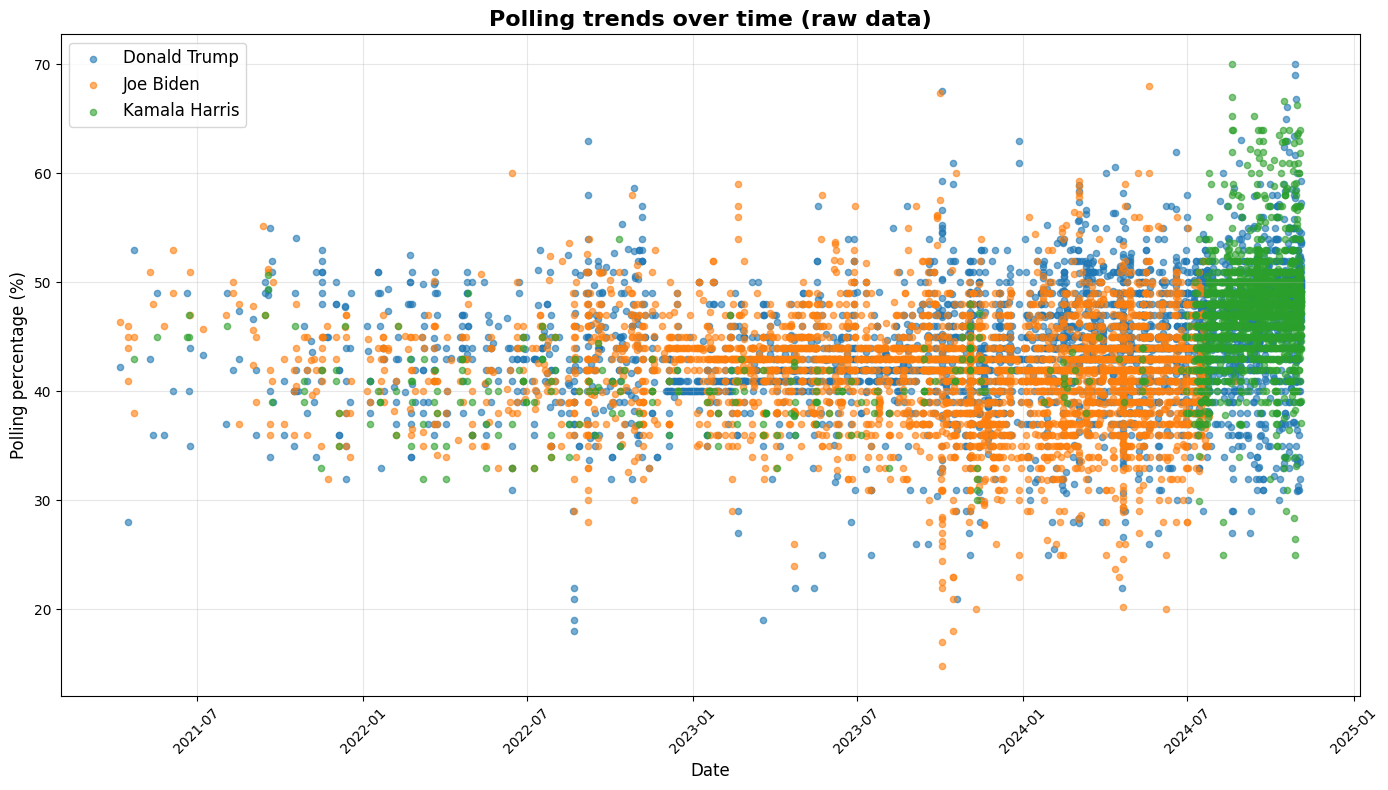

Visualization created with 12,508 data points
This shows raw polling data - you'll want to create averages for cleaner trends.


In [ ]:
# ============================================================================
# Quick visualization - polling trends
# ============================================================================

print("\nCREATING QUICK VISUALIZATION:")
print("=" * 80)

# Only create viz if we have the necessary data
can_visualize = all(
    col in df.columns for col in ["end_date_parsed", "candidate_name", "pct"]
)

if can_visualize:
    # Filter to main candidates for cleaner visualization
    viz_data = df[df["candidate_name"].isin(MAIN_CANDIDATES)].copy()

    if len(viz_data) > 0:
        # Create basic time series plot
        plt.figure(figsize=(14, 8))

        for candidate in MAIN_CANDIDATES:
            cand_data = viz_data[viz_data["candidate_name"] == candidate]
            if len(cand_data) > 0:
                # Sort by date and plot
                cand_data = cand_data.sort_values("end_date_parsed")
                plt.scatter(
                    cand_data["end_date_parsed"],
                    cand_data["pct"],
                    label=candidate,
                    alpha=0.6,
                    s=20,
                )

        plt.title("Polling trends over time (raw data)", fontsize=16, fontweight="bold")
        plt.xlabel("Date", fontsize=12)
        plt.ylabel("Polling percentage (%)", fontsize=12)
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        print(f"Visualization created with {len(viz_data):,} data points")
        print(f"This shows raw polling data.")
    else:
        print("No main candidate data available for visualization")
else:
    missing_cols = [
        col
        for col in ["end_date_parsed", "candidate_name", "pct"]
        if col not in df.columns
    ]
    print(f"Cannot create visualization - missing columns: {missing_cols}")

In [12]:
# ============================================================================
# Sample processing test
# ============================================================================

print("\nTESTING SAMPLE PROCESSING:")
print("=" * 80)

# Test processing on a small sample
sample_size = 1000
df_sample = df.head(sample_size).copy()

print(f"Testing with sample of {sample_size:,} rows...")

try:
    # Test date parsing
    if "end_date" in df_sample.columns:
        df_sample["end_date_clean"] = pd.to_datetime(
            df_sample["end_date"], format="mixed"
        )
        print("Date parsing works")

    # Test candidate filtering
    if "candidate_name" in df_sample.columns:
        df_sample_filtered = df_sample[
            df_sample["candidate_name"].isin(MAIN_CANDIDATES)
        ]
        print(f"Candidate filtering works: {len(df_sample_filtered)} rows retained")

    # Test percentage cleaning
    if "pct" in df_sample.columns:
        clean_pct = df_sample[
            (df_sample["pct"].notna())
            & (df_sample["pct"] >= 0)
            & (df_sample["pct"] <= 100)
        ]
        print(f"Percentage cleaning works: {len(clean_pct)} rows retained")

    # Test geographic categorization
    if "state" in df_sample.columns:
        df_sample["geographic_scope"] = df_sample["state"].apply(
            lambda x: (
                "National"
                if pd.isna(x)
                else ("Swing State" if x in SWING_STATES else "Other State")
            )
        )
        geo_counts = df_sample["geographic_scope"].value_counts()
        print(f"Geographic categorization works: {dict(geo_counts)}")

    print(f"\nSample processing successful! Ready for full pipeline.")

except Exception as e:
    print(f"Sample processing failed: {e}")
    print("Fix these issues before running full pipeline")


TESTING SAMPLE PROCESSING:
Testing with sample of 1,000 rows...
Date parsing works
Candidate filtering works: 670 rows retained
Percentage cleaning works: 1000 rows retained
Geographic categorization works: {'Swing State': np.int64(619), 'Other State': np.int64(197), 'National': np.int64(184)}

Sample processing successful! Ready for full pipeline.


In [ ]:
# ============================================================================
# Exploration summary and next steps
# ============================================================================

print("\n" + "=" * 80)
print("EXPLORATION SUMMARY & NEXT STEPS")
print("=" * 80)

print(f"DATASET OVERVIEW:")
print(f"   - Total records: {len(df):,}")
print(f"   - Columns: {len(df.columns)}")
print(f"   - Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

if "candidate_name" in df.columns:
    main_candidates_found = [
        c for c in MAIN_CANDIDATES if c in df["candidate_name"].values
    ]
    print(f"   - Main candidates found: {main_candidates_found}")

if "end_date_parsed" in df.columns:
    date_range = (
        f"{df['end_date_parsed'].min().date()} to {df['end_date_parsed'].max().date()}"
    )
    print(f"   - Date range: {date_range}")

print(f"\nWHAT WORKS:")
key_features = ["end_date", "candidate_name", "pct", "pollster", "state"]
working_features = [f for f in key_features if f in df.columns]
print(f"   Available key columns: {working_features}")

print(f"\nISSUES TO ADDRESS:")
# List any major issues found during exploration
if issues_found:
    for issue in issues_found:
        print(f"   {issue.replace('_', ' ').title()}")
else:
    print("   No major issues detected!")

print(f"\nRECOMMENDED NEXT STEPS:")
print(f"   (1) Fix any data quality issues identified above.")
print(f"   (2) Build production functions in a .py file based on this exploration.")
print(f"   (3) Start with basic processing: dates, candidates, percentages.")
print(
    f"   (4) Add advanced features: geographic scope, quality metrics, rolling averages."
)
print(f"   (5) Create Tableau-ready output with comprehensive features.")

print(f"\nREADY FOR PRODUCTION PIPELINE:")
if len(working_features) >= 4:  # At least end_date, candidate_name, pct, pollster
    print(f"   Yes! You have enough key columns to build a full pipeline.")
else:
    print(f"   Need to resolve missing key columns first.")


EXPLORATION SUMMARY & NEXT STEPS
DATASET OVERVIEW:
   • Total records: 18,095
   • Columns: 56
   • Memory usage: 32.7 MB
   - Main candidates found: ['Donald Trump', 'Joe Biden', 'Kamala Harris']
   - Date range: 2021-04-07 to 2024-11-04

WHAT WORKS:
   Available key columns: ['end_date', 'candidate_name', 'pct', 'pollster', 'state']

ISSUES TO ADDRESS:
   No major issues detected!

RECOMMENDED NEXT STEPS:
   (1) Fix any data quality issues identified above.
   (2) Build production functions in a .py file based on this exploration.
   (3) Start with basic processing: dates, candidates, percentages.
   (4) Add advanced features: geographic scope, quality metrics, rolling averages.
   (5) Create Tableau-ready output with comprehensive features.

READY FOR PRODUCTION PIPELINE:
   Yes! You have enough key columns to build a full pipeline.


In [14]:
# ============================================================================
# Export clean sample for testing
# ============================================================================

# Create a clean sample for initial Tableau testing
print(f"\nCREATING CLEAN SAMPLE FOR TABLEAU TESTING:")

try:
    # Start with sample data
    clean_sample = df.head(2000).copy()  # Manageable size for testing

    # Apply basic cleaning based on exploration
    if "end_date" in clean_sample.columns:
        clean_sample["end_date"] = pd.to_datetime(
            clean_sample["end_date"], format="mixed"
        )

    if "candidate_name" in clean_sample.columns:
        clean_sample = clean_sample[
            clean_sample["candidate_name"].isin(MAIN_CANDIDATES)
        ]

    if "pct" in clean_sample.columns:
        clean_sample = clean_sample[
            (clean_sample["pct"].notna())
            & (clean_sample["pct"] >= 0)
            & (clean_sample["pct"] <= 100)
        ]

    # Add basic features for Tableau
    if "end_date" in clean_sample.columns:
        clean_sample["year"] = clean_sample["end_date"].dt.year
        clean_sample["month_year"] = (
            clean_sample["end_date"].dt.to_period("M").astype(str)
        )

    if "state" in clean_sample.columns:
        clean_sample["geographic_scope"] = clean_sample["state"].apply(
            lambda x: (
                "National"
                if pd.isna(x)
                else ("Swing State" if x in SWING_STATES else "Other State")
            )
        )

    # Export sample
    output_file = "clean_polling_sample.csv"
    clean_sample.to_csv(output_file, index=False)

    print(f"   Created clean sample: {output_file}")
    print(f"   Sample size: {len(clean_sample):,} rows")
    print(f"   Use this for initial Tableau testing")

except Exception as e:
    print(f"   Failed to create clean sample: {e}")


CREATING CLEAN SAMPLE FOR TABLEAU TESTING:
   Created clean sample: clean_polling_sample.csv
   Sample size: 1,341 rows
   Use this for initial Tableau testing
